In [1]:
!pip install --quiet yfinance feedparser textblob nltk vaderSentiment transformers torch wordcloud

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import feedparser
import time
import yfinance as yf
import matplotlib.pyplot as plt
import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
url = "https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv"
sp500_df = pd.read_csv(url)
tickers = sp500_df["Symbol"].str.replace(".", "-", regex=False).tolist()

In [4]:
all_news = []

for t in tickers:
    rss = f"https://feeds.finance.yahoo.com/rss/2.0/headline?s={t}&region=US&lang=en-US"
    feed = feedparser.parse(rss)
    for e in feed.entries:
        all_news.append({
            "ticker": t,
            "title": e.get("title"),
            "published": e.get("published")
        })
    time.sleep(0.25)

news_df = pd.DataFrame(all_news)

In [5]:
news_df["published"] = pd.to_datetime(news_df["published"], errors="coerce")
news_df.dropna(inplace=True)
news_df = news_df.drop_duplicates(subset=["title", "published"])
news_df["date"] = news_df["published"].dt.date

In [6]:
analyzer = SentimentIntensityAnalyzer()
news_df["vader"] = news_df["title"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
news_df["textblob"] = news_df["title"].apply(lambda x: TextBlob(x).sentiment.polarity)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [10]:
def finbert_batch(texts, batch_size=32):
    scores = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        inputs = tokenizer(
            batch,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=128
        ).to(device)

        with torch.no_grad():
            logits = model(**inputs).logits
            probs = torch.softmax(logits, dim=1)

        batch_scores = (probs[:, 2] - probs[:, 0]).cpu().numpy()
        scores.extend(batch_scores)

    return scores

In [12]:
news_df["finbert"] = finbert_batch(news_df["title"].tolist(), batch_size=32)

In [44]:
ticker_daily = (
    news_df
    .groupby(["date", "ticker"])[["vader", "textblob", "finbert"]]
    .mean()
    .reset_index()
)

market_daily = (
    ticker_daily
    .groupby("date")[["vader", "textblob", "finbert"]]
    .mean()
    .reset_index()
)

In [45]:
market_daily = market_daily.sort_values("date")
market_daily["finbert_lag1"] = market_daily["finbert"].shift(1)
market_daily["finbert_lag2"] = market_daily["finbert"].shift(2)

In [46]:
ivv = yf.download(
    "IVV",
    start=market_daily["date"].min(),
    end=market_daily["date"].max()
)

ivv.columns = ivv.columns.get_level_values(0)
ivv = ivv.reset_index()
ivv["date"] = ivv["Date"].dt.date
ivv["return"] = ivv["Close"].pct_change()

/tmp/ipython-input-1558330893.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ivv = yf.download(
[*********************100%***********************]  1 of 1 completed


In [55]:
ticker_merged = pd.merge(
    ticker_daily,
    ivv[["date", "return"]],
    on="date",
    how="inner"
)

ticker_merged.dropna(inplace=True)

In [56]:
ticker_merged["direction"] = (ticker_merged["return"] > 0).astype(int)
ticker_merged["sentiment_sign"] = (ticker_merged["finbert"] > 0).astype(int)

cs_accuracy = (
    ticker_merged["direction"] == ticker_merged["sentiment_sign"]
).mean()

print(f"Cross-sectional Directional Accuracy = {cs_accuracy*100:.4f}%")
print(f"Total observations = {len(ticker_merged)}")

Cross-sectional Directional Accuracy = 51.3357%
Total observations = 4305


In [57]:
ivv["volatility"] = ivv["return"].rolling(5).std()

In [58]:
merged = pd.merge(
    market_daily,
    ivv[["date", "return", "volatility"]],
    on="date",
    how="inner"
)
merged.dropna(inplace=True)

In [59]:
vol_threshold = merged["volatility"].quantile(0.60)
sent_threshold = merged["finbert_lag1"].abs().quantile(0.60)

vol_filtered = merged[
    (merged["volatility"] > vol_threshold) &
    (merged["finbert_lag1"].abs() > sent_threshold)
].copy()

In [60]:
vol_filtered["direction"] = (vol_filtered["return"] > 0).astype(int)
vol_filtered["sentiment_sign"] = (vol_filtered["finbert_lag1"] > 0).astype(int)

vol_accuracy = (
    vol_filtered["direction"] == vol_filtered["sentiment_sign"]
).mean()

print(f"Volatility-Filtered Accuracy = {vol_accuracy*100:.4f}%")
print(f"Signal days used = {len(vol_filtered)}")

Volatility-Filtered Accuracy = 60.0000%
Signal days used = 5


In [61]:
merged[["vader", "textblob", "finbert", "finbert_lag1", "finbert_lag2", "return"]].corr()

,vader,textblob,finbert,finbert_lag1,finbert_lag2,return
vader,1.000000,0.153036,-0.016191,-0.297897,-0.170155,0.010226
textblob,0.153036,1.000000,0.250470,-0.036673,0.189457,0.027293
finbert,-0.016191,0.250470,1.000000,0.274161,-0.316827,-0.077350
finbert_lag1,-0.297897,-0.036673,0.274161,1.000000,0.108994,-0.068015
finbert_lag2,-0.170155,0.189457,-0.316827,0.108994,1.000000,-0.141241
return,0.010226,0.027293,-0.077350,-0.068015,-0.141241,1.000000


In [62]:
import statsmodels.api as sm

X = merged[["finbert_lag1"]]
X = sm.add_constant(X)
y = merged["return"]

model_ols = sm.OLS(y, X).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.2556
Date:                Sat, 10 Jan 2026   Prob (F-statistic):              0.615
Time:                        16:08:06   Log-Likelihood:                 202.12
No. Observations:                  57   AIC:                            -400.2
Df Residuals:                      55   BIC:                            -396.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0014      0.001      1.010      0.317      -0.001       0.004
finbert_lag1    -0.0020      0.004     -0.506      0.615      -0.010       0.006
==============================================================================
Omnibus:                        2.795   Durbin-Watson:                   1.682
Prob(Omnibus):                  0.247   Jarque-Bera (JB):                2.324
Skew:                          -0.495   Prob(JB):                        0.313
Kurtosis:                       3.013   Cond. No.                         4.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
X = merged[["finbert_lag1", "finbert_lag2"]]
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.6286
Date:                Sat, 10 Jan 2026   Prob (F-statistic):              0.537
Time:                        16:08:06   Log-Likelihood:                 202.65
No. Observations:                  57   AIC:                            -399.3
Df Residuals:                      54   BIC:                            -393.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0019      0.001      1.281      0.206      -0.001       0.005
finbert_lag1    -0.0015      0.004     -0.394      0.695      -0.009       0.006
finbert_lag2    -0.0031      0.003     -1.001      0.321      -0.009       0.003
==============================================================================
Omnibus:                        3.737   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                3.368
Skew:                          -0.594   Prob(JB):                        0.186
Kurtosis:                       2.930   Cond. No.                         4.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

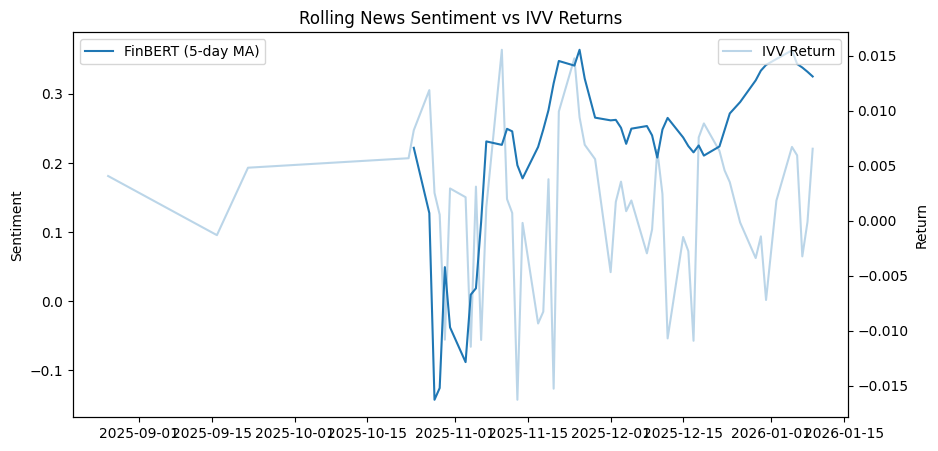

In [64]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(merged["date"], merged["finbert"].rolling(5).mean(), label="FinBERT (5-day MA)")
ax1.set_ylabel("Sentiment")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(merged["date"], merged["return"], alpha=0.3, label="IVV Return")
ax2.set_ylabel("Return")
ax2.legend(loc="upper right")

plt.title("Rolling News Sentiment vs IVV Returns")
plt.show()


In [69]:
merged["direction"] = (merged["return"] > 0).astype(int)
merged["sentiment_sign"] = (merged["finbert_lag1"] > 0).astype(int)

accuracy = (merged["direction"] == merged["sentiment_sign"]).mean()
accuracy_pct = accuracy * 100
print(f"Directional Accuracy = {accuracy_pct:.4f}%")
print(f"Total observations = {len(merged)}")

Directional Accuracy = 54.3860%
Total observations = 57
